# Pré-processamento

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cuda



O pré-processamento é essencial para uma padronização dos dados, além de transformá-los em tensor (formato utilizado em redes neurais).


*   Para fazer a normalização, é preciso fornecer valores da Média e o Desvio Padrão dos canais RGB. Esse cálculo foi feito seguindo o seguinte código:

```
# Normalização dados de treino/teste

stdR/meanR = 0
stdG/meanG = 0
stdB/meanB = 0

red = 0
green = 0
blue = 0

for i in range(len(train_dataset)):
  red += torch.std(train_dataset[i][0][0, 0, :, :])
  green += torch.std(train_dataset[i][0][0, 1, :, :])
  blue += torch.std(train_dataset[i][0][0, 2, :, :])



stdR/meanR = red/len(train_dataset)
stdG/meanG = green/len(train_dataset)
stdB/meanB = blue/len(train_dataset)
```
    (0.2781, 0.3548, 0.4237),
    (0.1859, 0.1956, 0.2309)


*   Esse processo é feito tanto para os dados de treino, quanto para os dados de teste, separadamente.







In [3]:
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
(0.2781, 0.3548, 0.4237),
(0.1859, 0.1956, 0.2309)
    ),
])

# 1) Dataset

Referências:


*   https://www.geeksforgeeks.org/os-module-python-examples/
*   https://docs.python.org/pt-br/3.7/library/os.path.html
*   https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#defining-the-dataset
*   https://discuss.pytorch.org/t/issue-with-stack-and-object-detection-dataloader/135748/2
*   https://discuss.pytorch.org/t/valueerror-expected-4d-input-got-3d-input/150585

*   https://stackoverflow.com/questions/56115874/how-to-convert-bounding-box-x1-y1-x2-y2-to-yolo-style-x-y-w-h













In [4]:
import os
import cv2
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader


class ForestFireDataset(Dataset):
  def __init__(self, data_path, transform=None):
    self.data_path = data_path
    self.transform = transform

    # listdir() é usado para obter a lista de todos os arquivos/diretórios no diretório especifico
    # os.path.join(path, *paths) faz a concatenação dos caminhos para separar os labels
    self.image_files = os.listdir(os.path.join(data_path, 'images'))
    self.image_labels = []

    # Pegando os rótulos para cada uma das imagens
    for image_file in self.image_files:
        label_file = os.path.splitext(image_file)[0] + '.txt'
        # Criando o arquivo da imagem associando ao label
        label_path = os.path.join(data_path, 'labels', label_file)
        with open(label_path, 'r') as f:
            lines = f.readlines()
            boxes = []
            for next_line in lines:
                # Convertendo o formato YOLO para
                #um formato padrão de Caixa Delimitadora (Xmin, Ymin, Xmax, Ymax)
                box = [float(x) for x in next_line.strip().split(' ')]
                box[1] = int(box[1] * 250) # Xcentro
                box[2] = int(box[2] * 250) # Ycentro
                box[3] = int(box[3] * 250) # Width
                box[4] = int(box[4] * 250) # Height


                # Armazenando os valores
                xtemp = box[1]
                ytemp = box[2]

                box[1] = box[1] - (box[3]/2)
                box[1] = float(format(box[1]/250,'.5f'))

                box[2] = box[2] - (box[4]/2)
                box[2] = float(format(box[2]/250,'.5f'))

                box[3] = xtemp + (box[3]/2)
                box[3] = float(format(box[3]/250,'.5f'))

                box[4] = ytemp + (box[4]/2)
                box[4] = float(format(box[4]/250,'.5f'))

                #print("Caixas normalizadas: ", box)
                boxes.append(box)
            self.image_labels.append(boxes)

  # É preciso ajustar a maneira como os dados serão empilhados, pois
  # cada imagem tem uma quantidade diferente de objetos
  def collate_fn(self, batch):
    return tuple(zip(*batch))

  def __len__(self):
    return len(self.image_files)

  def exibirImagem(self, index):
      image_path = os.path.join(self.data_path, 'images', self.image_files[index])
      img = cv2.imread(image_path)
      print(self.image_files[index])
      cv2_imshow(img)
      print("Caixas Delimitadoras: ", self.image_labels[index])

  def __getitem__(self, index):
      image_path = os.path.join(self.data_path, 'images', self.image_files[index])
      img = cv2.imread(image_path)

      if self.transform:
        img = self.transform(img)

      # Na hora da iteração sobre o dataloader, o valor do batch acaba se perdendo
      # e por isso precisamos adicionar uma dimensão manualmente
      img = img.unsqueeze(0)

      boxes = self.image_labels[index]
      num_boxes = len(boxes)
      boxes_tensor = torch.tensor(boxes, dtype=torch.float64)

      return img, boxes_tensor

Fórmulas de conversão do formato YOLO para um formato mais convencional:



*   YOLO - (Classe, Xcentro, Ycentro, Largura, Altura)
*   Convencional - (Classe, Xmin, Ymin, Xmax, Ymax)



    -> x0 = x - (w/2)
    -> y0 = y - (h/2)
    -> x1 = x + (w/2)
    -> y1 = y + (h/2)





In [5]:
batch_size = 32

path_test ='/content/drive/Shareddrives/TCC - Vinicius/Códigos/Dataset (Rotulado)/Forest Fire Dataset/Testing'
path_train='/content/drive/Shareddrives/TCC - Vinicius/Códigos/Dataset (Rotulado)/Forest Fire Dataset/Training'

train_dataset = ForestFireDataset(data_path=path_train,  transform=transform_train)
test_dataset = ForestFireDataset(data_path=path_test, transform=transform_train)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=test_dataset.collate_fn)

print(len(train_dataset))
print(len(test_dataset))




1520
380


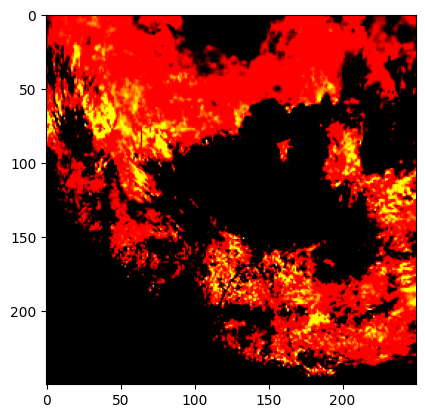

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# convert this image to numpy array
img = train_dataset[4][0].squeeze()
img_normalized = np.array(img)

img_normalized = img_normalized.transpose(1, 2, 0)
img_BGR = cv2.cvtColor(img_normalized, cv2.COLOR_RGB2BGR)

# display the normalized image
plt.imshow(img_BGR)

fire_0651.jpg


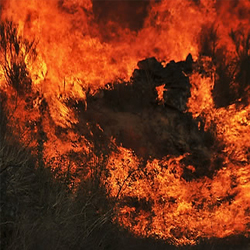

Caixas Delimitadoras:  [[1.0, 0.728, 0.268, 0.872, 0.476], [1.0, 0.85, 0.406, 0.998, 0.954], [1.0, 0.408, 0.58, 0.856, 0.972], [1.0, 0.004, 0.006, 0.364, 0.402], [1.0, 0.016, 0.408, 0.312, 0.592], [1.0, 0.16, 0.542, 0.432, 0.77], [1.0, 0.366, 0.004, 0.562, 0.356], [1.0, 0.568, 0.002, 1.0, 0.262], [1.0, 0.61, 0.33, 0.67, 0.414]]


In [7]:
train_dataset.exibirImagem(4)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=test_dataset.collate_fn)

# 2) Modelo da Rede
Referências:

*   https://arxiv.org/pdf/1512.02325.pdf (Artigo de criação da SSD)
*   https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/Detection/SSD/ssd/model.py
*   https://stats.stackexchange.com/questions/397767/how-do-backbone-and-head-architecture-work-in-mask-r-cnn#:~:text=The%20backbone%20refers%20to%20the,you%27ve%20labeled%20as%20FCN
*  https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/
*   https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html?highlight=object%20detection
*   https://github.com/adrianosantospb/detector_classificaodor_do_zero

## 2.1) O Backbone (Extração das caracteristicas)

*  Rede Base que será utilizada no processo de extração dos mapas de caracteristicas, utilizaremos ResNet50.




In [10]:
import torch
import torch.nn as nn
from torchvision.models.resnet import resnet50

class ResNet(nn.Module):
    def __init__(self, backbone='resnet50', backbone_path=None):
        super().__init__()

        backbone = resnet50(weights='IMAGENET1K_V2')

        self.out_channels = [1024, 512, 512, 256, 256, 256]
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:7])

        conv4_block1 = self.feature_extractor[-1][0]

        conv4_block1.conv1.stride = (1, 1)
        conv4_block1.conv2.stride = (1, 1)
        conv4_block1.downsample[0].stride = (1, 1)

    def forward(self, x):
        x = self.feature_extractor(x)
        return x

## 2.2) Modelo SSD

Criação das Caixas Delimitadoras, para variar escalar e formas das previsões.

In [11]:
def num_default_boxes(aspect_ratios: list) -> list:

    num_defaults_per_cell = []

    for aspect_ratio in aspect_ratios:
        num_defaults = 2 + len(aspect_ratio) * 2
        num_defaults_per_cell.append(num_defaults)

    return num_defaults_per_cell

def total_of_default_boxes(num_defaults_per_cell, feature_map_sizes):

    total = 0

    for ratio, size in zip(num_defaults_per_cell, feature_map_sizes):
        total += ratio * size * size

    return total

In [12]:
import torch.nn.functional as F

class SSD(nn.Module):

    def __init__(self, num_classes):
        super(SSD, self).__init__()

        self.num_classes = num_classes
        self.feature_extractor = ResNet()
        self.loc = []
        self.conf = []

        out_channels = self.feature_extractor.out_channels
        num_defaults_per_cell = num_default_boxes(
            [[2], [2,3], [2,3], [2,3], [2], [2]]
        )

        print("Feature extractor: ", out_channels)
        print("Caixas padrão: ", num_defaults_per_cell)

        for num_anchors, output_channels in zip(num_defaults_per_cell, out_channels):
            self.loc += self.bbox_predictor(output_channels, num_anchors)
            self.conf += self.cls_predictor(output_channels, num_anchors, num_classes)


    def cls_predictor(self, out_channels, num_anchors, num_classes):
        return [
            nn.Conv2d(out_channels, num_anchors*num_classes, kernel_size=3, padding=1).to(device),
            nn.Dropout(0.3)

        ]

    def bbox_predictor(self, out_channels, num_anchors):
        return [
            nn.Conv2d(out_channels, num_anchors*4, kernel_size=3, padding=1).to(device),
            nn.Dropout(0.3)
        ]

    def forward(self, x):

        features = []
        loc = []
        conf = []
        features.append(self.feature_extractor(x))

        for idx, feature_map in enumerate(features):
            loc.append(
                self.loc[idx](feature_map).permute(0, 2, 3, 1).contiguous().to(device)
            )
            conf.append(
                self.conf[idx](feature_map).permute(0, 2, 3, 1).contiguous().to(device)
            )

        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)


        #predicted_boxes = box_iou(self.dboxes.dboxes.to(device), loc[0])

        return (conf, loc)

In [13]:
model = SSD(num_classes=2).to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 256MB/s]


Feature extractor:  [1024, 512, 512, 256, 256, 256]
Caixas padrão:  [4, 6, 6, 6, 4, 4]


SSD(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=T

# 3) Treinamento e Validação

## 3.1) Função de treino

In [14]:
from torchvision.ops import box_iou

def train(model, dataloader, cls_loss, bbox_loss, optimizer):
  model.train()
  cumloss = 0.0
  total = 0
  correct = 0

  for imgs, labels in dataloader:
    imgs, labels = imgs[0].to(device), labels[0].to(device)

    optimizer.zero_grad()

    cls_pred, bbox_pred = model(imgs)
    cls_pred = cls_pred[0]
    bbox_pred = bbox_pred[0]

    scores = torch.argmax(cls_pred, dim=1)
    scores = scores.to(torch.float32)

    if len(labels) == 0: continue

    cls_reais = labels[:, 0]
    bbox_reais = labels[:, 1:]

    size = cls_reais.shape[0]
    iou = box_iou(bbox_reais, bbox_pred)

    valores = []
    indices = []
    for indice in iou:
      valor, id = torch.max(indice, dim=0)
      indices.append(id.item())
      valores.append(valor.item())

    N = 0
    for v in valores:
      if v > 0.5:
        N += 1



    loss_cls = cls_loss(scores[indices], cls_reais)
    loss_bbox = bbox_loss(bbox_pred[indices], bbox_reais)

    if N == 0: loss_total = loss_cls + loss_bbox
    else: loss_total = (loss_cls + loss_bbox)/N

    correct = N
    total = cls_reais.size(0)
    acc = (correct / total) * 100

    loss_total.backward()
    optimizer.step()
    cumloss += loss_total.item()

  return cumloss / len(dataloader), acc

## 3.2) Função de validação

In [15]:
def validate(model, dataloader, cls_loss, bbox_loss):
  model.eval()
  cumloss = 0.0

  with torch.no_grad():
    for imgs, labels in dataloader:
      imgs, labels = imgs[0].to(device), labels[0].to(device)

      cls_pred, bbox_pred = model(imgs)
      cls_pred = cls_pred[0]
      bbox_pred = bbox_pred[0]

      scores = torch.argmax(cls_pred, dim=1)
      scores = scores.to(torch.float32)

      cls_reais = labels[:, 0]
      bbox_reais = labels[:, 1:]

      size = cls_reais.shape[0]
      iou = box_iou(bbox_reais, bbox_pred)

      valores = []
      indices = []
      for linhas in range(iou.shape[0]):
        valor, id = torch.max(iou[linhas], dim=0)
        indices.append(id.item())
        valores.append(valor.item())

      N = 0
      for v in valores:
        if v > 0.5:
          N += 1

      #print("Maiores Valores (teste): ", valores)

      loss_cls = cls_loss(scores[indices], cls_reais)
      loss_bbox = bbox_loss(bbox_pred[indices], bbox_reais)

      #if N == 0: loss_total =  (loss_cls + loss_bbox) * 0.0
      #else: loss_total =  (loss_cls + loss_bbox)/N

      if N == 0: loss_total = loss_cls + loss_bbox
      else: loss_total = (loss_cls + loss_bbox)/N

      cumloss += loss_total.item()

  return cumloss / len(dataloader)

## 3.3) Treinamento

In [ ]:
cls_loss = nn.CrossEntropyLoss(reduction='sum')
bbox_loss = nn.SmoothL1Loss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.0005, momentum=0.8)

epochs = 150

train_loss = []
test_loss = []
mean_acc = 0

torch.cuda.empty_cache()
for t in range(epochs):
  loss_train, train_acc = train(model, train_loader, cls_loss, bbox_loss, optimizer)
  train_loss.append(loss_train)
  mean_acc += train_acc
  if t % 5 == 0:
    print(f"Epoch: {t}; Train Loss: {loss_train}")
  loss_test = validate(model, test_loader, cls_loss, bbox_loss)
  test_loss.append(loss_test)

print("Acurácia Média: ", mean_acc/epochs)

Epoch: 0; Train Loss: 10.552762481257332


In [9]:
import matplotlib.pyplot as plt

def plot_losses(losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");

losses = {"Train loss": train_loss, "Test loss": test_loss}
plot_losses(losses)

NameError: ignored

# 4) Detecção

In [35]:
import cv2
from numpy import asarray
from google.colab.patches import cv2_imshow

def visualize(image, detection, classes):

    labels = ['Nao fogo', 'Fogo']

    box = detection.cpu().numpy()
    classe = classes.cpu().numpy()

    x0 = box[0] * 250
    y0 = box[1] * 250
    x1 = box[2] * 250
    y1 = box[3] * 250

    numpydata = asarray(image)
    print("x0: ", int(x0))
    print("y0: ", int(y0))
    print("Largura: ", int(x1))
    print("Altura: ", int(y1))


    cv2.rectangle(numpydata , (x0.astype(int), y0.astype(int)), (x1.astype(int), y1.astype(int)), (0, 255, 0), 2)

    label = labels[int(classe)]
    print(label)
    cv2.putText(numpydata , label, (x1.astype(int), y1.astype(int) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # exibe a imagem
    img_convertida = cv2.cvtColor(numpydata, cv2.COLOR_RGB2BGR)
    cv2_imshow(img_convertida)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

torch.Size([3119])
tensor([0.2952, 0.5458, 0.6312, 0.5612], device='cuda:0')
x0:  73
y0:  136
Largura:  157
Altura:  140
Fogo


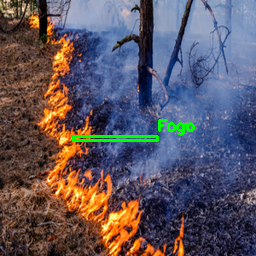

In [39]:
from PIL import Image
from torchvision.ops import nms

image = Image.open("/content/drive/MyDrive/imagemTeste.jpg")

transform = transforms.Compose([
    transforms.Resize(size=(250, 250)),
    transforms.ToTensor(),
    transforms.Normalize(
    (0.2781, 0.3548, 0.4237),
    (0.1859, 0.1956, 0.2309)
  ),
])

image_tensor = transform(image).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    classes, caixas = model(image_tensor)

classes = classes[0]
caixas = caixas[0]

scores, cls_pred = torch.max(classes, dim=1)
indices = nms(boxes=caixas, scores=scores, iou_threshold=0.05)
print(indices.shape)

boxes = caixas[indices]
classes = cls_pred[indices]

image = image.resize((256, 256))
print(boxes[1])
visualize(image, boxes[1], classes[1])